Long short term memory (LSTM) is a model that increases the memory of recurrent neural networks. Recurrent neural networks hold short term memory in that they allow earlier determining information to be employed in the current neural networks. For immediate tasks, the earlier data is used. We may not possess a list of all of the earlier information for the neural node. In RNNs, LSTMs are very widely used in Neural networks. Their effectiveness should be implemented to multiple sequence modelling problems in many application domains like video, NLP, geospatial, and time-series.
One of the main issues with RNN is the vanishing gradient problem, and it emerges due to the repeated use of the same parameters, in RNN blocks, at each step. We must try to use different parameters to overcome this problem at each time step.
We try to find a balance in such a situation. We bring novel parameters at each step while generalizing variable-length sequences and keeping the overall amount of learnable parameters constant. We introduce gated RNN cells like LSTM and GRU.
Gated cells hold internal variables, which are Gates. This value of each gate at each time step depends on the information at that time step, including early states. The value of the gate then becomes multiplied by the different variables of interest to influence them. Time-series data is a series of data values gathered over time interims, allowing us to trace differences over time. Time-series data can trace progress over milliseconds, days, and years.
Early, our perspective of time-series data meant more static; the everyday highs and lows under temperature, the opening and closing amount of the stock market. Now we will go to the coding part. We will implement LSTM on the stocks dataset.

# Implementation of LSTM on stocks data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
google_stock_data = pd.read_csv('GOOG.csv')
google_stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


Exploring Dataset:

The dataset contains 14 columns associated with time series like the date and the different variables like close, high, low and volume. We will use opening and closing values for our experimentation of time series with LSTM.

In [3]:
google_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [4]:
google_stock_data = google_stock_data[['date','open','close']] # Extracting required columns
google_stock_data['date'] = pd.to_datetime(google_stock_data['date'].apply(lambda x: x.split()[0])) # Selecting only date
google_stock_data.set_index('date',drop=True,inplace=True) # Setting date column as index
google_stock_data.head()

,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71


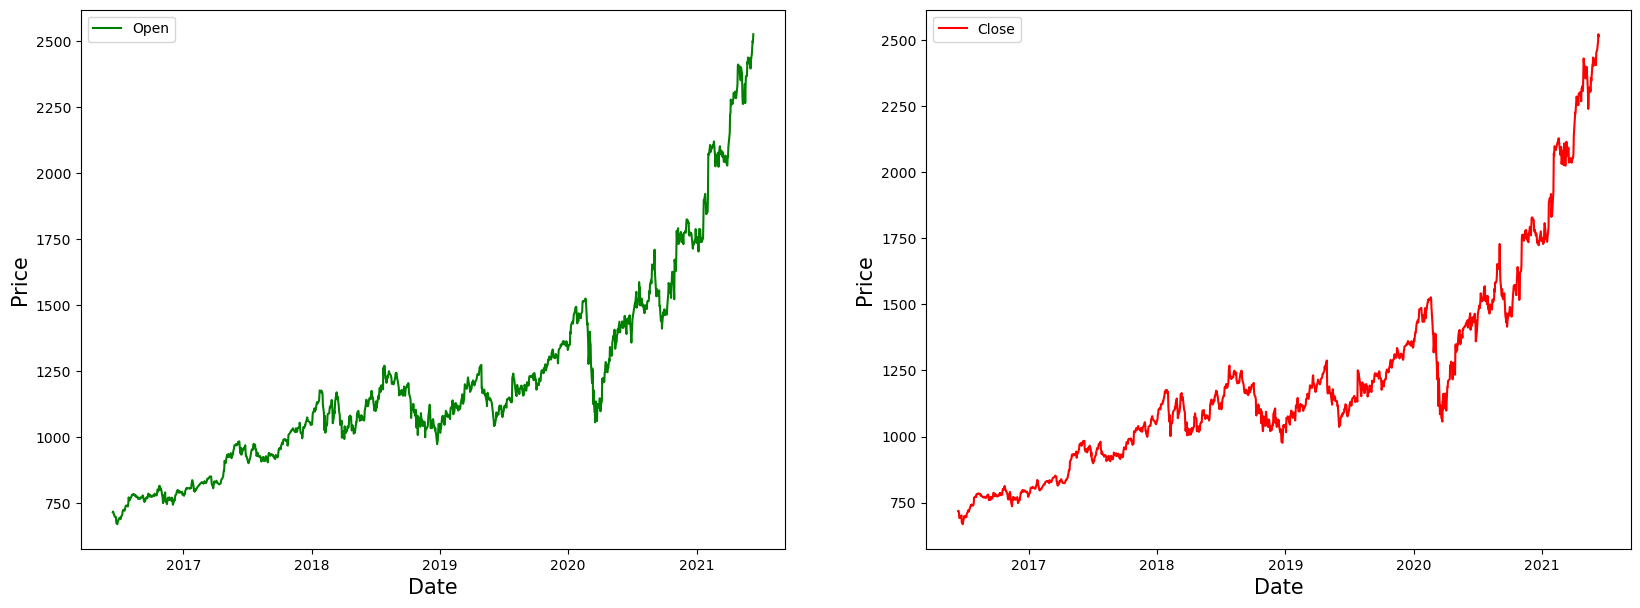

In [5]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(google_stock_data['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(google_stock_data['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

Data Pre-processing:

We must pre-process this data before applying stock price using LSTM. Transform the values in our data with help of the fit_transform function. Min-max scaler is used for scaling the data so that we can bring all the price values to a common scale. We then use 80 % data for training and the rest 20% for testing and assign them to separate variables.

In [6]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
google_stock_data[google_stock_data.columns] = MMS.fit_transform(google_stock_data)


In [7]:
google_stock_data.shape

(1258, 2)

In [8]:
training_size = round(len(google_stock_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

1006

In [9]:
train_data = google_stock_data[:training_size]
test_data  = google_stock_data[training_size:]

train_data.shape, test_data.shape

((1006, 2), (252, 2))

In [10]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [11]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [12]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((956, 50, 2), (956, 2), (202, 50, 2), (202, 2))

# Creating LSTM model

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
30/30 [==============================] - 6s 63ms/step - loss: 0.0088 - mean_absolute_error: 0.0652 - val_loss: 0.0145 - val_mean_absolute_error: 0.0933
Epoch 2/80
30/30 [==============================] - 1s 33ms/step - loss: 7.2913e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0024 - val_mean_absolute_error: 0.0387
Epoch 3/80
30/30 [==============================] - 1s 31ms/step - loss: 5.1146e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0023 - val_mean_absolute_error: 0.0375
Epoch 4/80
30/30 [==============================] - 1s 32ms/step - loss: 4.8178e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0029 - val_mean_absolute_error: 0.0428
Epoch 5/80
30/30 [==============================] - 1s 32ms/step - loss: 4.6625e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0022 - val_mean_absolute_error: 0.0365
Epoch 6/80
30/30 [==============================] - 1s 32ms/step - loss: 4.3704e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0024 - val_mean_absolute_error: 0.0382
Ep

In [16]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

7/7 [==============================] - 1s 10ms/step


array([[0.47457188, 0.47725692],
       [0.4813011 , 0.4838558 ],
       [0.48540217, 0.48791692],
       [0.4994955 , 0.5021111 ],
       [0.51155525, 0.5139972 ]], dtype=float32)

In [17]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[1550.8184, 1552.7793],
       [1563.2937, 1565.0093],
       [1570.8969, 1572.5359],
       [1597.0247, 1598.8425],
       [1619.3826, 1620.8716]], dtype=float32)

In [18]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([google_stock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=google_stock_data.iloc[-202:].index)], axis=1)

In [19]:
gs_slic_data[['open','close']] = MMS.inverse_transform(gs_slic_data[['open','close']]) # Inverse scaling

In [20]:
gs_slic_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,1593.98,1588.20,1550.818359,1552.779297
2020-08-25,1582.07,1608.22,1563.293701,1565.009277
2020-08-26,1608.00,1652.38,1570.896851,1572.535889
2020-08-27,1653.68,1634.33,1597.024658,1598.842529
2020-08-28,1633.49,1644.41,1619.382568,1620.871582


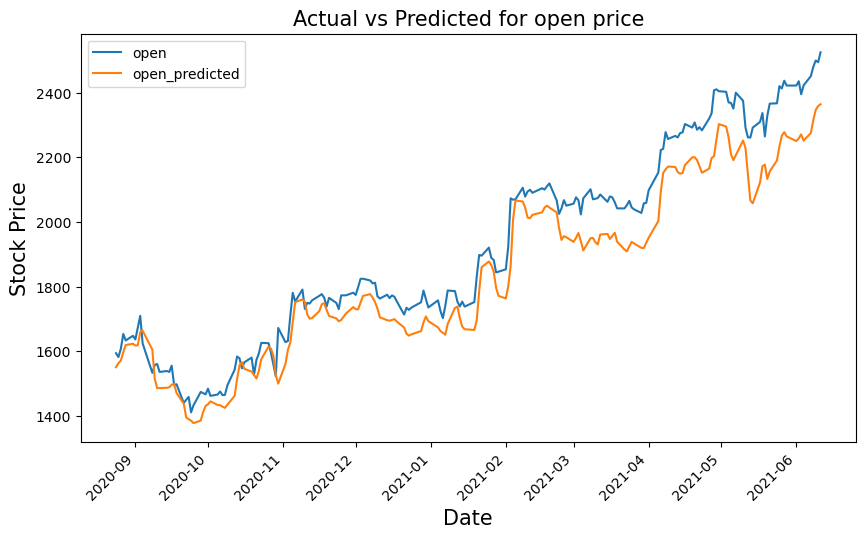

In [21]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

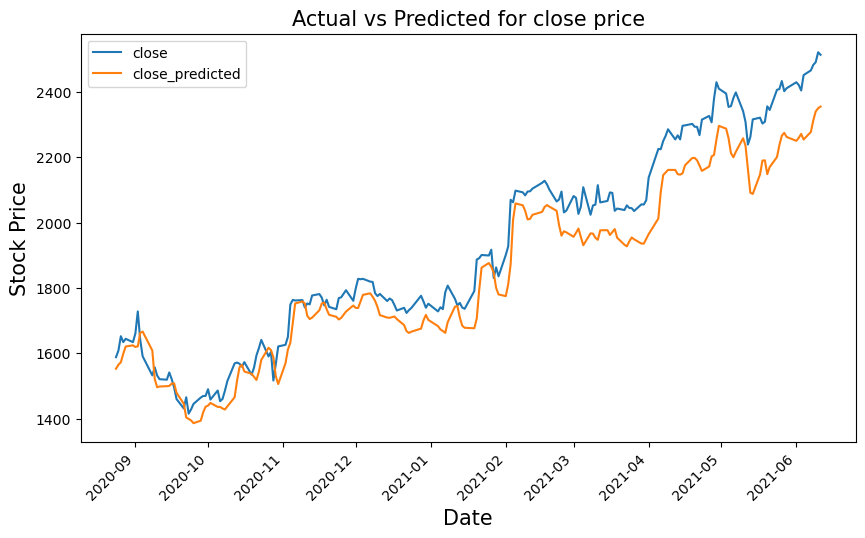

In [22]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

# Predicting upcoming 10 days

In [23]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))

In [24]:
gs_slic_data['2021-06-09	':'2021-06-16']

,open,close,open_predicted,close_predicted
2021-06-09,2499.50,2491.40,2346.403564,2340.447021
2021-06-10,2494.01,2521.60,2358.413330,2350.212402
2021-06-11,2524.92,2513.93,2364.191895,2355.278809
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


In [25]:
upcoming_prediction = pd.DataFrame(columns=['open','close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [26]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 27ms/step


In [27]:
upcoming_prediction[['open','close']] = MMS.inverse_transform(upcoming_prediction[['open','close']])

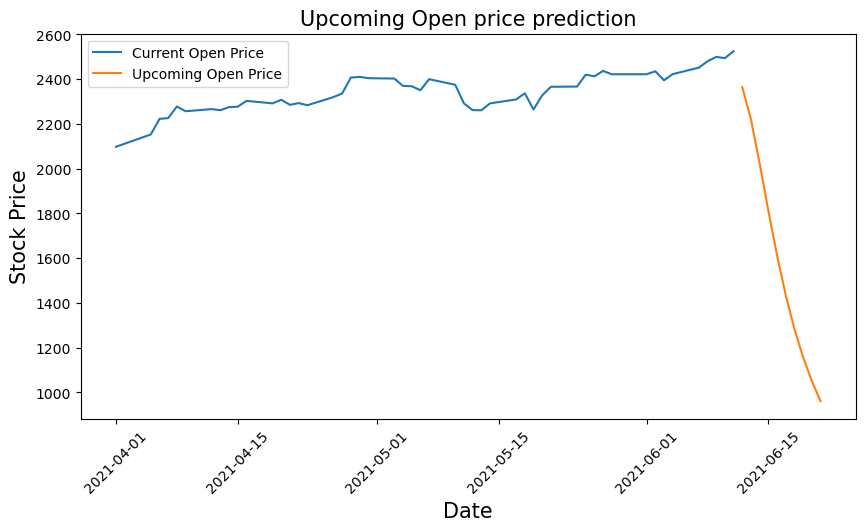

In [28]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

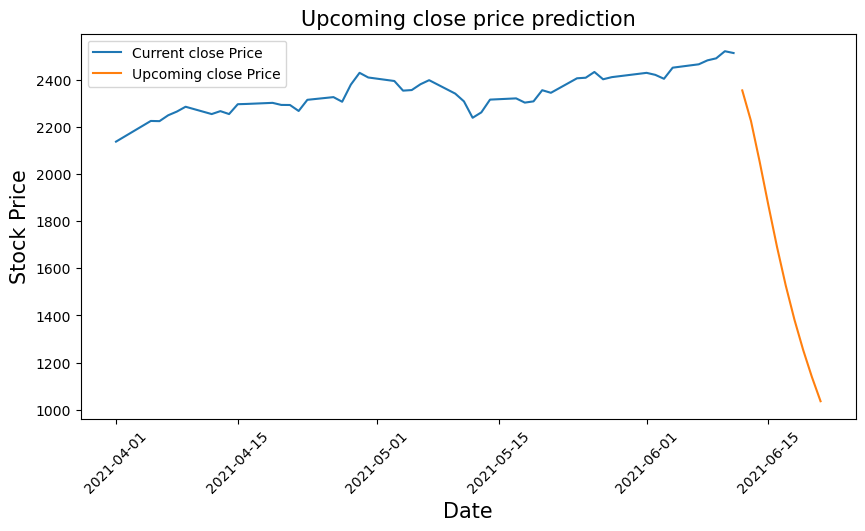

In [29]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()